In [1]:
%matplotlib inline

import glob
import logging
import numpy as np
import os
import pylab
import colour
from colour.plotting import *
from colour_hdri.camera_response_functions import (
    camera_response_function_Debevec1997)
from colour_hdri.image import Image, ImageStack
from colour_hdri.radiance import radiance_image
from colour_hdri.weighting_functions import weighting_function_Debevec1997

LOGGER = logging.getLogger()
LOGGER.setLevel(logging.DEBUG)

OECF = colour.RGB_COLOURSPACES['sRGB'].transfer_function

RESOURCES_DIRECTORY = os.path.join(os.getcwd(), 'resources')
JPG_FILES = glob.glob('{0}/*.jpg'.format(RESOURCES_DIRECTORY))

INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2600.jpg" image.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2600.jpg" image metadata.
INFO:colour_hdri.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2600.jpg' file exif data.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2601.jpg" image.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2601.jpg" image metadata.
INFO:colour_hdri.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2601.jpg' file exif data.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Develop

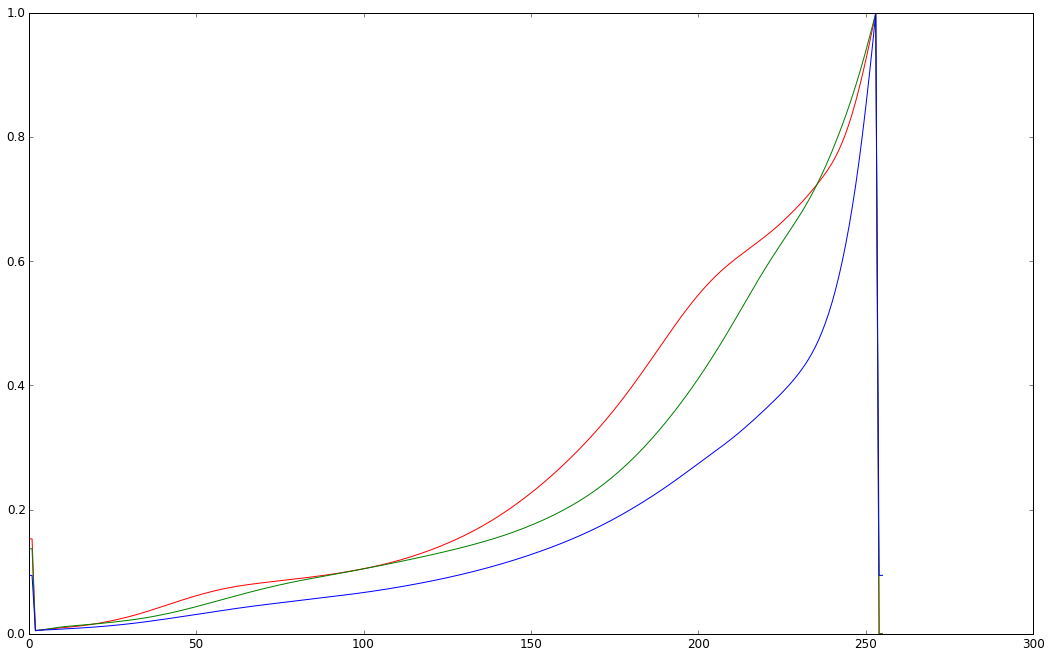

In [2]:
def camera_response_functions(jpg_files):
    image_stack = ImageStack()
    for jpg_file in jpg_files:
        image = Image(jpg_file)
        image.read_data()
        image.read_metadata()
        image_stack.append(image)

    crfs = camera_response_function_Debevec1997(image_stack)
    crfs /= np.max(crfs, axis=0)

    return crfs


CRFS = camera_response_functions(JPG_FILES)

pylab.plot(CRFS)
pylab.show()

INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2600.jpg" image.


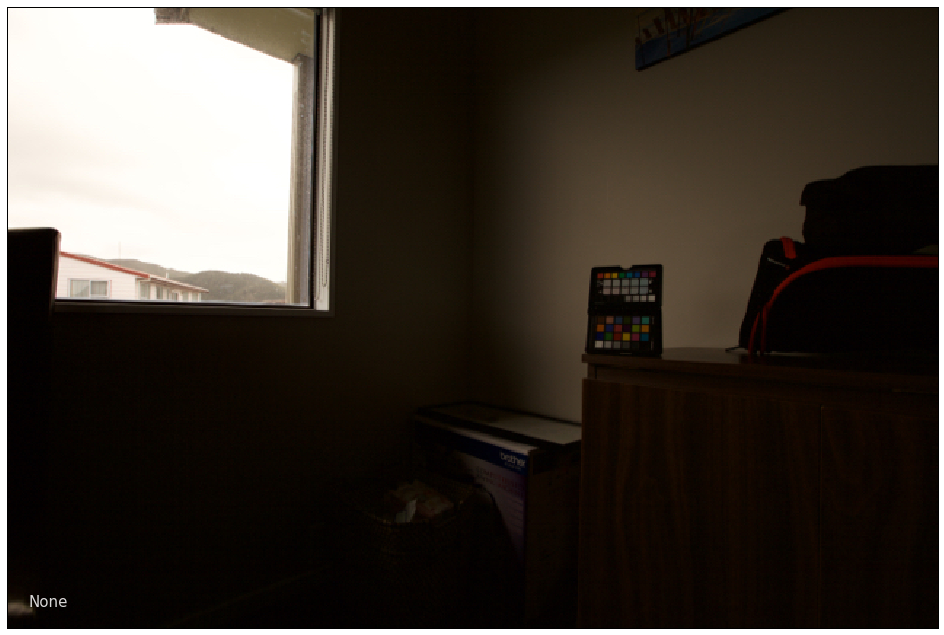

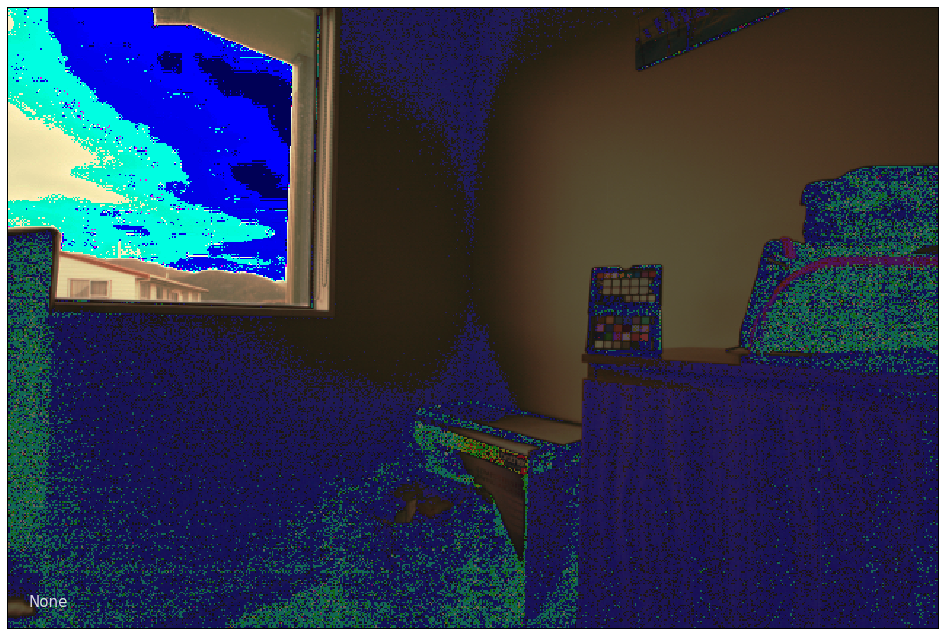

INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2600.jpg" image metadata.
INFO:colour_hdri.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2600.jpg' file exif data.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2601.jpg" image.


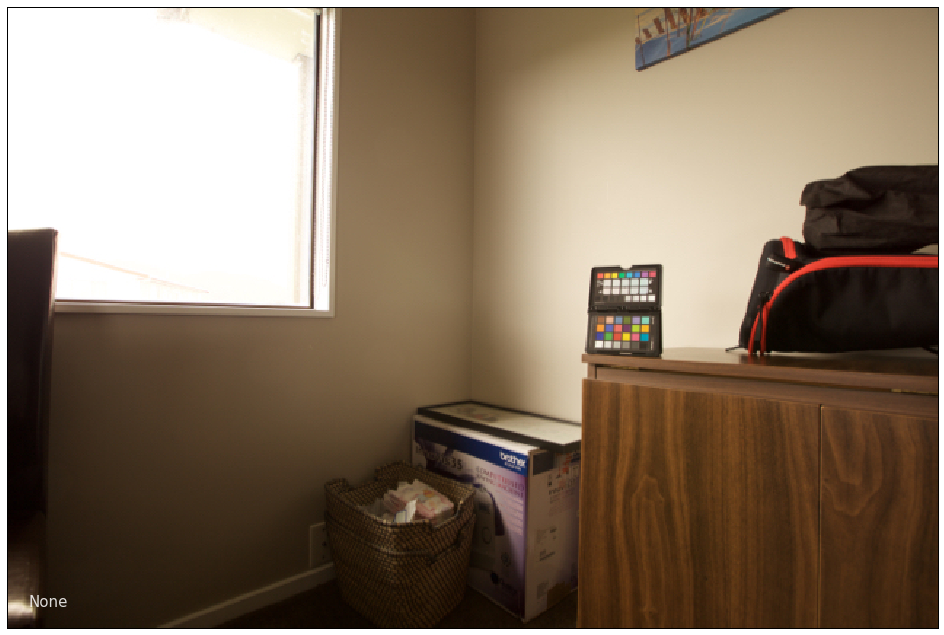

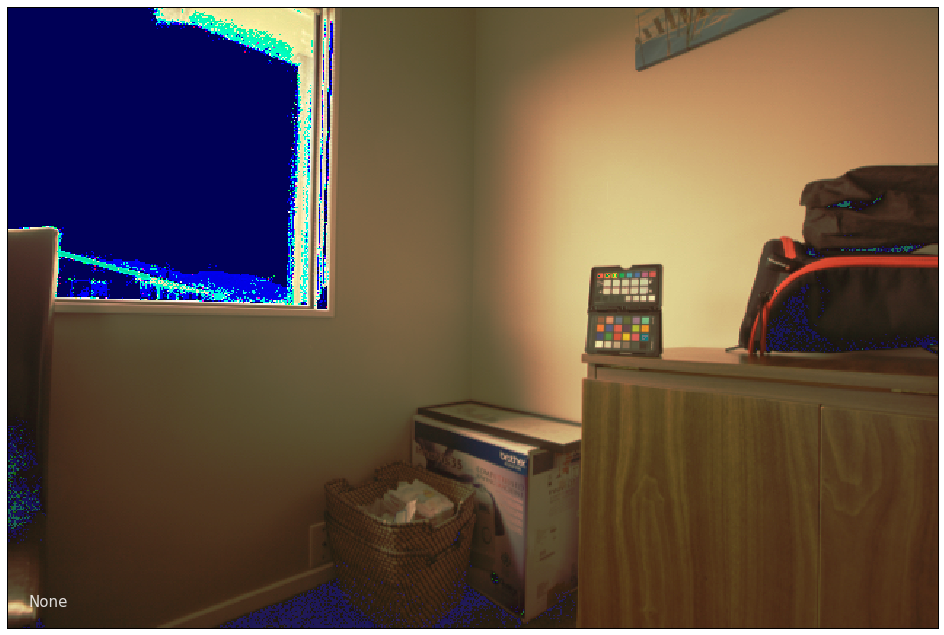

INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2601.jpg" image metadata.
INFO:colour_hdri.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2601.jpg' file exif data.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2602.jpg" image.


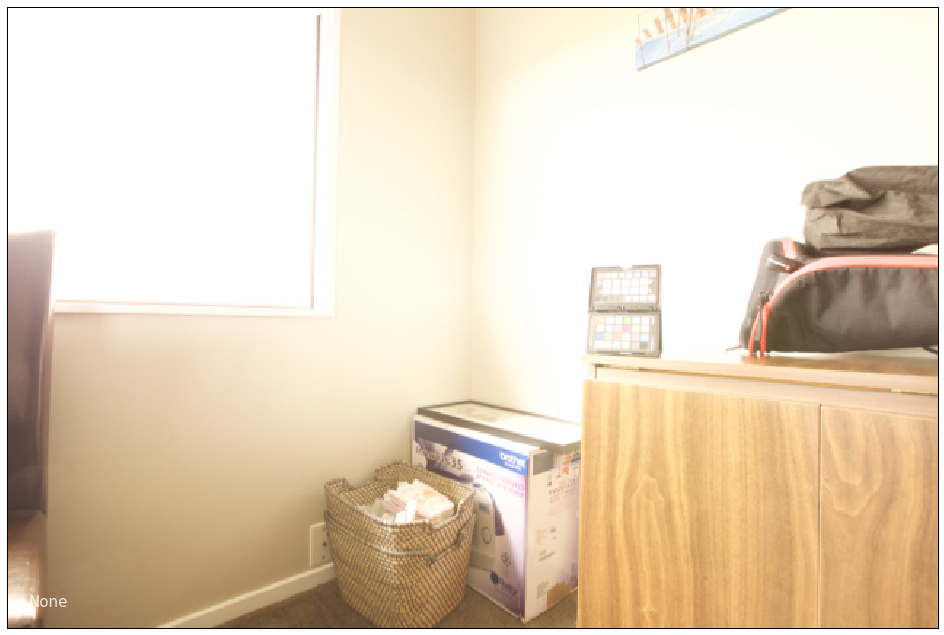

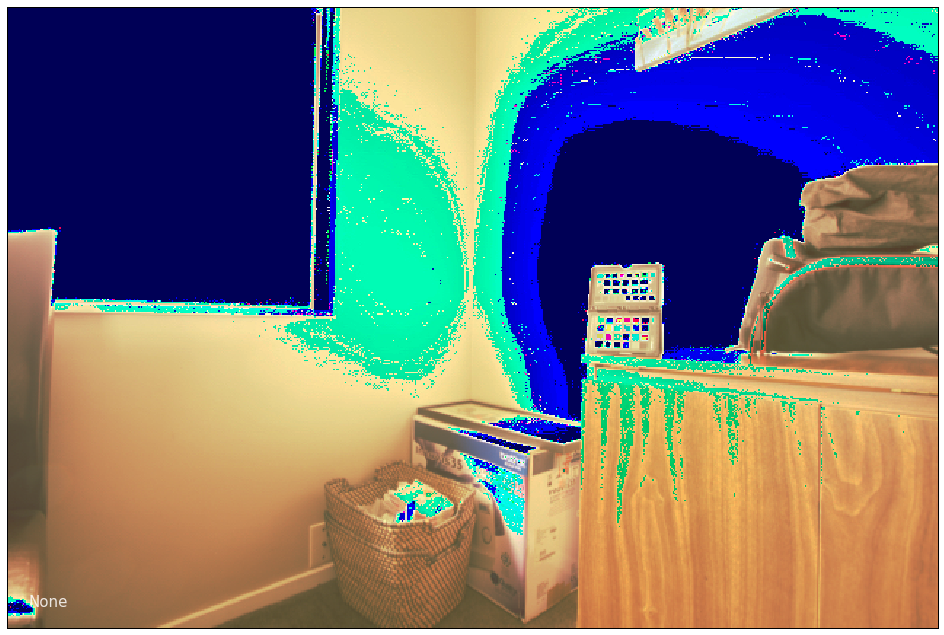

INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2602.jpg" image metadata.
INFO:colour_hdri.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2602.jpg' file exif data.
INFO:root:Merging "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2600_5_MLF.exr"...
INFO:root:	Image stack "F Number" (Exif): [ 8.  8.  8.]
INFO:root:	Image stack "Exposure Time" (Exif): [ 0.002       0.01666667  0.125     ]
INFO:root:	Image stack "ISO" (Exif): [ 100.  100.  100.]
/Users/kelsolaar/Documents/Development/Environments/colour-hdri/lib/python2.7/site-packages/colour_hdri/radiance.py:46: RuntimeWarning: invalid value encountered in true_divide
  image_c /= weight_c
INFO:root:Writing "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2600_5_MLF.exr"...


In [3]:
def example_merge_from_jpg_files(
        jpg_files,
        output_directory,
        crfs,
        batch_size=5,
        weight_function=weighting_function_Debevec1997):
    samples = np.linspace(0, 1, crfs.shape[0])
    for jpg_files in colour.batch(jpg_files, batch_size):
        image_stack = ImageStack()
        for jpg_file in jpg_files:
            image = Image(jpg_file)
            image.read_data()
            R, G, B = colour.tsplit(image.data)
            R = np.interp(R, samples, crfs[..., 0])
            G = np.interp(G, samples, crfs[..., 1])
            B = np.interp(B, samples, crfs[..., 2])
            image_plot(image.data)
            image.data = colour.tstack((R, G, B))
            image_plot(OECF(image.data))
            image.read_metadata()
            image_stack.append(image)
        
        path = os.path.join(
            output_directory,
            '{0}_{1}_MLF.{2}'.format(
                os.path.splitext(os.path.basename(image_stack.path[0]))[0],
                batch_size,
                'exr'))
        
        LOGGER.info('Merging "{0}"...'.format(path))
        LOGGER.info('\tImage stack "F Number" (Exif): {0}'.format(
            image_stack.f_number))
        LOGGER.info('\tImage stack "Exposure Time" (Exif): {0}'.format(
            image_stack.exposure_time))
        LOGGER.info('\tImage stack "ISO" (Exif): {0}'.format(
            image_stack.iso))
        image = radiance_image(image_stack, weight_function)
        image[np.isnan(image)] = 0
        
        LOGGER.info('Writing "{0}"...'.format(path))
        colour.write_image(image, path)

        return image, path

IMAGE, PATH = example_merge_from_jpg_files(JPG_FILES, RESOURCES_DIRECTORY, CRFS)